# Predicting Taxi Out Time for Flights Leaving JFK Airport

### Content
The objective of this project is to build a model which predicts Taxi-Out time for flights leaving JFK airport based on data taken between November 2019 to December 2020. Taxi-Out prediction has been an important concept as it helps in calculating Runway time and directly impacts the cost of the flight and more importantly, this helps avoid accidents.

### Context
The dataset was scraped under an Academic Paper under Review by IEEE Transportation.

It contains data on approximately 2,100 flights and includes 23 columns with various components that might be relevant to determine Tax-Out time. 

The full dataset we used for analysis can be found and downloaded [here](https://www.kaggle.com/deepankurk/flight-take-off-data-jfk-airport).

## Exploring the Dataset

We start by importing the libraries and classes we will use and reading the dataset into Pandas.

In [800]:
# Import the libraries and classes we will use

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import BayesianRidge
from sklearn.svm import SVR 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor 

# Read the dataset into pandas as a dataframe
flights = pd.read_csv('M1_final.csv')

# Verify the number of rows and columns
flights.shape

(28820, 23)

The dataset has 28,820 rows and 23 columns. Below, we show the first 5 rows of the data.

In [801]:
# Display the first 5 rows of the data
flights.head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,TAIL_NUM,DEST,DEP_DELAY,CRS_ELAPSED_TIME,DISTANCE,CRS_DEP_M,...,Dew Point,Humidity,Wind,Wind Speed,Wind Gust,Pressure,Condition,sch_dep,sch_arr,TAXI_OUT
0,11,1,5,B6,N828JB,CHS,-1,124,636,324,...,34,58,W,25,38,29.86,Fair / Windy,9,17,14
1,11,1,5,B6,N992JB,LAX,-7,371,2475,340,...,34,58,W,25,38,29.86,Fair / Windy,9,17,15
2,11,1,5,B6,N959JB,FLL,40,181,1069,301,...,34,58,W,25,38,29.86,Fair / Windy,9,17,22
3,11,1,5,B6,N999JQ,MCO,-2,168,944,345,...,34,58,W,25,38,29.86,Fair / Windy,9,17,12
4,11,1,5,DL,N880DN,ATL,-4,139,760,360,...,32,58,W,24,35,29.91,Fair / Windy,9,17,13


In [802]:
#print all headers
list(flights.columns)

['MONTH',
 'DAY_OF_MONTH',
 'DAY_OF_WEEK',
 'OP_UNIQUE_CARRIER',
 'TAIL_NUM',
 'DEST',
 'DEP_DELAY',
 'CRS_ELAPSED_TIME',
 'DISTANCE',
 'CRS_DEP_M',
 'DEP_TIME_M',
 'CRS_ARR_M',
 'Temperature',
 'Dew Point',
 'Humidity',
 'Wind',
 'Wind Speed',
 'Wind Gust',
 'Pressure',
 'Condition',
 'sch_dep',
 'sch_arr',
 'TAXI_OUT']

#### Rename the column names for clarity

Looking at the column names above, it would be useful to rename some to make it clearer what the data is. I have done this below. 

In [803]:
col_names = {"OP_UNIQUE_CARRIER":"CARRIER_CODE",
                "TAIL_NUM":"FLIGHT_NO",
                "CRS_ELAPSED_TIME":"SCHEDULED_DURATION",
                "CRS_DEP_M":"SCHEDULED_DEPARTURE",
                "DEP_TIME_M":"ACTUAL_DEP_TIME",
                "CRS_ARR_M":"SCHEDULED_ARRIVAL",
                "sch_dep":"FLT_SCH_ARRIVAL",
                "sch_arr":"FLT_SCH_DEPARTURE"}  #create dictionary of headings

flights = flights.rename(col_names, axis=1) #replace headings
flights.head() #check headings have been replaced correctly

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,CARRIER_CODE,FLIGHT_NO,DEST,DEP_DELAY,SCHEDULED_DURATION,DISTANCE,SCHEDULED_DEPARTURE,...,Dew Point,Humidity,Wind,Wind Speed,Wind Gust,Pressure,Condition,FLT_SCH_ARRIVAL,FLT_SCH_DEPARTURE,TAXI_OUT
0,11,1,5,B6,N828JB,CHS,-1,124,636,324,...,34,58,W,25,38,29.86,Fair / Windy,9,17,14
1,11,1,5,B6,N992JB,LAX,-7,371,2475,340,...,34,58,W,25,38,29.86,Fair / Windy,9,17,15
2,11,1,5,B6,N959JB,FLL,40,181,1069,301,...,34,58,W,25,38,29.86,Fair / Windy,9,17,22
3,11,1,5,B6,N999JQ,MCO,-2,168,944,345,...,34,58,W,25,38,29.86,Fair / Windy,9,17,12
4,11,1,5,DL,N880DN,ATL,-4,139,760,360,...,32,58,W,24,35,29.91,Fair / Windy,9,17,13


We have renamed the columns in the `flights` dataset successfully.

#### Checking datatypes 
Below, we explore the type of data stored under each column. Since we are running a linear regression model, it would be useful to convert data to numerical data where possible.

In [804]:
# Display further info about each column 
flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28820 entries, 0 to 28819
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   MONTH                28820 non-null  int64  
 1   DAY_OF_MONTH         28820 non-null  int64  
 2   DAY_OF_WEEK          28820 non-null  int64  
 3   CARRIER_CODE         28820 non-null  object 
 4   FLIGHT_NO            28820 non-null  object 
 5   DEST                 28820 non-null  object 
 6   DEP_DELAY            28820 non-null  int64  
 7   SCHEDULED_DURATION   28820 non-null  int64  
 8   DISTANCE             28820 non-null  int64  
 9   SCHEDULED_DEPARTURE  28820 non-null  int64  
 10  ACTUAL_DEP_TIME      28820 non-null  int64  
 11  SCHEDULED_ARRIVAL    28820 non-null  int64  
 12  Temperature          28820 non-null  int64  
 13  Dew Point            28820 non-null  object 
 14  Humidity             28820 non-null  int64  
 15  Wind                 28818 non-null 

#### Notes for preparing the data later
1. The `Dew Point` feature should be converted to an integer datatype as it is numerical data.
2. The `Wind` feature can also be converted to numerical data by turning this to degrees.
3. The `Carrier_Code`, `Flight_No`, `DEST` (destination) and `Condition` are object datatypes and should be numerically encoded.

## Preparing the data for modelling

As noted above, we need to prepare the data to ensure it is in a suitable format for modelling. 

#### 1. Dealing with Missing Values
We check for any missing values below.




In [805]:
flights.isnull().sum()

MONTH                  0
DAY_OF_MONTH           0
DAY_OF_WEEK            0
CARRIER_CODE           0
FLIGHT_NO              0
DEST                   0
DEP_DELAY              0
SCHEDULED_DURATION     0
DISTANCE               0
SCHEDULED_DEPARTURE    0
ACTUAL_DEP_TIME        0
SCHEDULED_ARRIVAL      0
Temperature            0
Dew Point              0
Humidity               0
Wind                   2
Wind Speed             0
Wind Gust              0
Pressure               0
Condition              0
FLT_SCH_ARRIVAL        0
FLT_SCH_DEPARTURE      0
TAXI_OUT               0
dtype: int64

There are only 2 missing values which are under the `Wind` feature. I looked at the two columns more closely to see whether they can be dropped or if any of the values are significant in which case we should keep the row.

In [806]:
flights_na = flights[flights.isna().any(axis=1)]
print(flights_na)

       MONTH  DAY_OF_MONTH  DAY_OF_WEEK CARRIER_CODE FLIGHT_NO DEST  \
15156     12            19            4           B6    N648JB  FLL   
15157     12            19            4           9E    N136EV  PWM   

       DEP_DELAY  SCHEDULED_DURATION  DISTANCE  SCHEDULED_DEPARTURE  ...  \
15156         60                 189      1069                 1275  ...   
15157          3                  83       273                 1349  ...   

       Dew Point  Humidity  Wind Wind Speed  Wind Gust Pressure  \
15156         10        55   NaN          0          0    30.42   
15157         10        55   NaN          0          0    30.42   

           Condition  FLT_SCH_ARRIVAL  FLT_SCH_DEPARTURE TAXI_OUT  
15156  Mostly Cloudy               21                 33       41  
15157  Mostly Cloudy               21                 33       40  

[2 rows x 23 columns]


Next, we check if any of the above data is signficant by comparing the values with the average, minimum and maximum values for the entire dataset.

Below, we see that the `TAXI_OUT` time for both rows is relatively high compared to the rest of the entries. Row 15156 has the highest `TAXI_OUT` time in our dataset. I therefore decided to keep both rows and replace the missing values. 

In [807]:
# check description of each column and more info about numerical data
flights.describe()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,DEP_DELAY,SCHEDULED_DURATION,DISTANCE,SCHEDULED_DEPARTURE,ACTUAL_DEP_TIME,SCHEDULED_ARRIVAL,Temperature,Humidity,Wind Speed,Wind Gust,Pressure,FLT_SCH_ARRIVAL,FLT_SCH_DEPARTURE,TAXI_OUT
count,28820.000000,28820.000000,28820.000000,28820.000000,28820.000000,28820.000000,28820.000000,28820.000000,28820.000000,28820.000000,28820.000000,28820.000000,28820.000000,28820.000000,28820.000000,28820.000000,28820.000000
mean,7.894240,16.021096,4.008952,6.374983,225.288203,1267.746079,831.003851,828.934698,910.874289,41.489833,57.732616,12.367627,5.535323,30.092433,31.091256,28.432130,20.858570
std,4.991723,8.750179,1.985230,38.735144,119.482417,889.343246,299.398525,305.864103,345.411743,8.043533,23.468676,6.259298,11.886457,0.296160,9.510359,8.263043,6.851915
min,1.000000,1.000000,1.000000,-22.000000,57.000000,94.000000,301.000000,1.000000,1.000000,17.000000,0.000000,0.000000,0.000000,29.200000,0.000000,0.000000,5.000000
25%,1.000000,8.000000,2.000000,-6.000000,124.000000,483.000000,545.000000,542.000000,667.000000,36.000000,46.000000,8.000000,0.000000,29.880000,26.000000,21.000000,16.000000
50%,11.000000,16.000000,4.000000,-3.000000,188.000000,1029.000000,856.000000,854.000000,918.000000,42.000000,59.000000,12.000000,0.000000,30.110000,30.000000,30.000000,19.000000
75%,12.000000,24.000000,6.000000,2.000000,365.000000,2248.000000,1095.000000,1097.000000,1193.000000,47.000000,74.000000,16.000000,0.000000,30.320000,37.000000,35.000000,25.000000
max,12.000000,31.000000,7.000000,1276.000000,697.000000,4983.000000,1439.000000,1440.000000,1439.000000,68.000000,97.000000,36.000000,49.000000,30.750000,55.000000,46.000000,41.000000


#### Replacing the missing values

I then looked at the different values under the `Wind` column and how many times each value appears.

In [808]:
# check frequency of values
flights['Wind'].value_counts()

W       3273
NW      3173
NNW     2570
WSW     2567
N       2453
SW      2354
WNW     2145
S       1879
SSW     1632
NNE     1280
ENE     1124
E       1068
NE      1044
CALM     835
ESE      466
SE       345
SSE      315
VAR      295
Name: Wind, dtype: int64

The most common value for the Wind feature is W therefore I will use this to replace the missing value.
We see later on that there is a low correlation between the `Wind` and `Taxi_Out` features, so I believe this approach is appropraite and will not have any significant impact on the data that will make it less accurate.

In [809]:
#replace missing values under the 'Wind' feature with W
flights['Wind'] = flights['Wind'].fillna(value='W')

#verify that we have replaced all missing values
flights.isnull().sum()

MONTH                  0
DAY_OF_MONTH           0
DAY_OF_WEEK            0
CARRIER_CODE           0
FLIGHT_NO              0
DEST                   0
DEP_DELAY              0
SCHEDULED_DURATION     0
DISTANCE               0
SCHEDULED_DEPARTURE    0
ACTUAL_DEP_TIME        0
SCHEDULED_ARRIVAL      0
Temperature            0
Dew Point              0
Humidity               0
Wind                   0
Wind Speed             0
Wind Gust              0
Pressure               0
Condition              0
FLT_SCH_ARRIVAL        0
FLT_SCH_DEPARTURE      0
TAXI_OUT               0
dtype: int64

We have successfully replaced all missing values and there are no other missing values in the dataset.

#### 2. Converting the `Wind` feature into numerical data (degrees)
I then converted the `Wind` feature which describes the wind's cardinal direction into degrees. 

In [810]:
# assign a degree for each value and store this in a dictionary
wind_dict = {'NNW': 340, 'CALM': 0, 'NNE':20, 'NE':45, 'VAR':0, 'WSW':230, 'S':180, 'SSW':200, 'WNW':290, 'ESE':115, 'N': 360, 'SW':225, 'E':90, 'W':270, 'SSE':155, 'ENE':70, 'NW':315, 'SE':135}

# replace the values in the dataframe as per the wind_dict dictionary
for i in wind_dict:
    flights.loc[flights['Wind'] == i, "Wind"] = wind_dict[i]

# convert the dtype to an integer
flights['Wind'] = flights['Wind'].astype('int')

#### 3. Converting the `Dew Point` feature to an integer data type
First, I converted the `Dew Point` feature which is currently an objet dtype to an integer dtype.

In [811]:
flights['Dew Point'] = flights['Dew Point'].astype('int')

In [812]:
# Check that we have successfully made the above changes

flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28820 entries, 0 to 28819
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   MONTH                28820 non-null  int64  
 1   DAY_OF_MONTH         28820 non-null  int64  
 2   DAY_OF_WEEK          28820 non-null  int64  
 3   CARRIER_CODE         28820 non-null  object 
 4   FLIGHT_NO            28820 non-null  object 
 5   DEST                 28820 non-null  object 
 6   DEP_DELAY            28820 non-null  int64  
 7   SCHEDULED_DURATION   28820 non-null  int64  
 8   DISTANCE             28820 non-null  int64  
 9   SCHEDULED_DEPARTURE  28820 non-null  int64  
 10  ACTUAL_DEP_TIME      28820 non-null  int64  
 11  SCHEDULED_ARRIVAL    28820 non-null  int64  
 12  Temperature          28820 non-null  int64  
 13  Dew Point            28820 non-null  int64  
 14  Humidity             28820 non-null  int64  
 15  Wind                 28820 non-null 

To recap, I have:
* replaced all the missing values (2 instances) under the `Wind` feature with the most common value, i.e. 'W' (for 'West')
* converted the `Wind` values from the cardinal directions into degrees so it is in a numerical format
* converted the `Dew Point` feature from an object dtype to an integer

As we can see above, our dataframe includes some categorical data which are stored as object datatypes. We will convert these values to numerical data using LabelEncoder later on.

__*Further Work For Future*__ *As an extension to this project and with more time available, I would like to convert these categorical values to numerical data for one hot encoding. This could make the model more accurate.*

## Further Exploration

We will now check for any numeric columns with the high correlation levels with our target column `TAXI_OUT` i.e. Taxi-out time. A high correlation with the target indicates that the feature have a high weighting in our model. 

We will consider the absolute value of the correlation, since both negative and positive correlation with `TAXI_OUT` are relevant for modeling.

Below, we plot the correlation of the numerical columns against our target column, `TAXI_OUT`.



<AxesSubplot:>

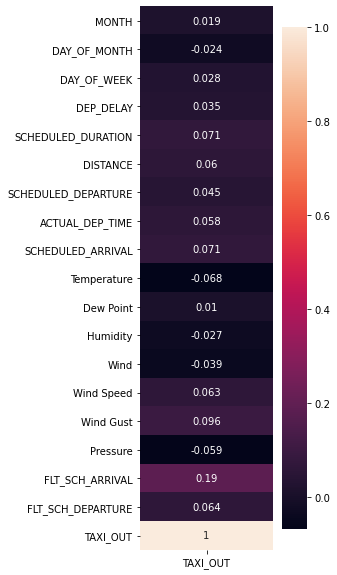

In [813]:
corr =  flights.corr().loc[:,['TAXI_OUT']]
plt.figure(figsize = (3,10))

sns.heatmap(corr,annot = True)

No signifcant correlations.

## Running the Models

In this final section, we use the following algorithms to fit our data into a model which we can then use to predict `TAXI_OUT` delay. 

1. Linear Regression
2. Ridge Regression(Popularily L1)
3. Lasso Regression(Popularily L2)
4. KNeighbors Regression
5. Bayesian Ridge
6. Random Forest

We will then test the accuracy of each model by calculating the mean squared error and root mean squared error. The lower the error, the more accurate the model.

In [814]:
#copy dataframe for label encoding
flights_label = flights.copy()

flights.head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,CARRIER_CODE,FLIGHT_NO,DEST,DEP_DELAY,SCHEDULED_DURATION,DISTANCE,SCHEDULED_DEPARTURE,...,Dew Point,Humidity,Wind,Wind Speed,Wind Gust,Pressure,Condition,FLT_SCH_ARRIVAL,FLT_SCH_DEPARTURE,TAXI_OUT
0,11,1,5,B6,N828JB,CHS,-1,124,636,324,...,34,58,270,25,38,29.86,Fair / Windy,9,17,14
1,11,1,5,B6,N992JB,LAX,-7,371,2475,340,...,34,58,270,25,38,29.86,Fair / Windy,9,17,15
2,11,1,5,B6,N959JB,FLL,40,181,1069,301,...,34,58,270,25,38,29.86,Fair / Windy,9,17,22
3,11,1,5,B6,N999JQ,MCO,-2,168,944,345,...,34,58,270,25,38,29.86,Fair / Windy,9,17,12
4,11,1,5,DL,N880DN,ATL,-4,139,760,360,...,32,58,270,24,35,29.91,Fair / Windy,9,17,13


In [815]:
# set input variables 
X = flights_label.drop(['TAXI_OUT'], axis = 1)
# set variable to predict (taxi_out time) 
y = flights_label['TAXI_OUT']

# store object datatypes into 'objects' variable
objects = list(X.select_dtypes(include = 'object').columns)

#store numeric datatypes into 'numerics' variable
numerics = list(set(X.columns) - set(objects))

# copy dataframe of only input input variables
X = X.copy() 

In [816]:
# convert object datatypes to numerical labels
label_encoder = LabelEncoder() 
for i in objects:
    X[i] = label_encoder.fit_transform(X[i].astype(str))

#### Setting training data and data for testing

I decided to use 80% of the data to train the models and the remaining 20% to test the accuracy of the models.

In [817]:
# Split the dataset into 80% training data and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 1)

In [818]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Linear Regression

In [819]:
lr_mod = LinearRegression() # define Linear Regression model
lr_mod.fit(X_train, y_train) # fit model onto training data
lr_pred = lr_mod.predict(X_test) # make prediction based on test data

In [820]:
lr_mse = mean_squared_error(y_test,lr_pred) # calculate mean squared error
lr_rmse = mean_squared_error(y_test,lr_pred)**0.5 # calculate root mean squared error
print("Mean squared error: %.2f" % lr_mse)
print("Root mean squared error: %.2f" % lr_rmse)

Mean squared error: 42.94
Root mean squared error: 6.55


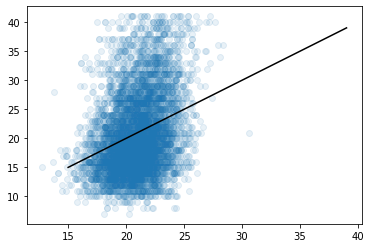

In [853]:
plt.scatter(lr_pred, y_test, alpha=0.1) # plot scatter graph of predicted data from linear regression model vs test data
plt.plot(np.arange(15,40),np.arange(15,40), color='k')o


### KNeighbors Regressor

In [854]:
kn_mod = KNeighborsRegressor()
kn_mod.fit(X_train,y_train)
kn_pred = kn_mod.predict(X_test)


In [855]:
kn_mse = mean_squared_error(y_test,kn_pred)
kn_rmse = mean_squared_error(y_test,kn_pred)**0.5 # calculate root mean squared error
print("Mean squared error: %.2f" % kn_mse)
print("Root mean squared error: %.2f" % kn_rmse)

Mean squared error: 41.72
Root mean squared error: 6.46


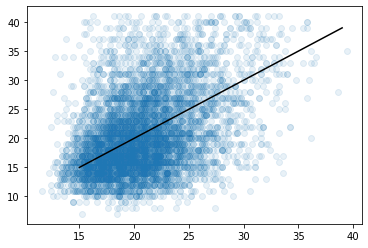

In [856]:
plt.scatter(kn_pred, y_test, alpha = 0.1) #plot scatter graph of predicted data from kneighbors regressor model vs test data
plt.plot(np.arange(15,40),np.arange(15,40), color='k')

### Lasso Regression

In [857]:
la_mod = Lasso(alpha=0.05)
la_mod.fit(X_train,y_train)
la_pred = la_mod.predict(X_test)

In [858]:
la_mse = mean_squared_error(y_test,la_pred)
la_rmse = mean_squared_error(y_test,la_pred)**0.5 # calculate root mean squared error
print("Mean squared error: %.2f" % la_mse)
print("Root mean squared error: %.2f" % la_rmse)

Mean squared error: 43.23
Root mean squared error: 6.57


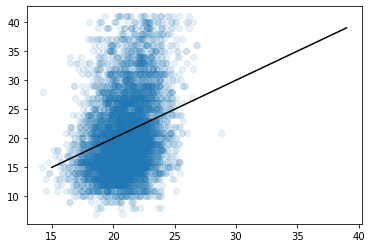

In [859]:
plt.scatter(la_pred, y_test, alpha = 0.1) #plot scatter graph of predicted data from lasso model vs test data
plt.plot(np.arange(15,40),np.arange(15,40), color='k')

### Ridge Regression


In [860]:
rr_mod = Ridge(alpha=0.05)
rr_mod.fit(X_train,y_train)
rr_pred = rr_mod.predict(X_test)

In [861]:
rr_mse = mean_squared_error(y_test,rr_pred)
rr_rmse = mean_squared_error(y_test,rr_pred)**0.5 # calculate root mean squared error
print("Mean squared error: %.2f" % rr_mse)
print("Root mean squared error: %.2f" % rr_rmse)

Mean squared error: 42.94
Root mean squared error: 6.55


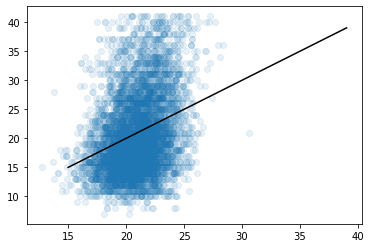

In [862]:
plt.scatter(rr_pred, y_test, alpha = 0.1) #plot scatter graph oh predicted data from ridge regression model vs test data
plt.plot(np.arange(15,40),np.arange(15,40), color='k')

### Bayesian Ridge 

In [863]:
br_mod = BayesianRidge()
br_mod.fit(X_train,y_train)
br_pred = br_mod.predict(X_test)

In [864]:
br_mse = mean_squared_error(y_test,br_pred)
br_rmse = mean_squared_error(y_test,br_pred)**0.5 # calculate root mean squared error
print("Mean squared error: %.2f" % br_mse)
print("Root mean squared error: %.2f" % br_rmse)

Mean squared error: 42.99
Root mean squared error: 6.56


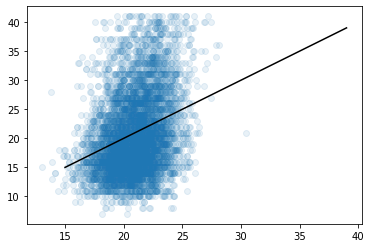

In [865]:
plt.scatter(br_pred, y_test, alpha=0.1) #plot scatter graph of predicted data from bayesian ridge model vs test data
plt.plot(np.arange(15,40),np.arange(15,40), color='k') # plot the 1:1 line

### Random Forest Regressor

In [866]:
rf_mod = RandomForestRegressor()
rf_mod.fit(X_train,y_train)
rf_pred = rf_mod.predict(X_test)

In [867]:
rf_mse = mean_squared_error(y_test,rf_pred) #calculate mean squared error
rf_rmse = mean_squared_error(y_test,rf_pred)**0.5 # calculate root mean squared error
print("Mean squared error: %.2f" % rf_mse)
print("Root mean squared error: %.2f" % rf_rmse)

Mean squared error: 32.22
Root mean squared error: 5.68


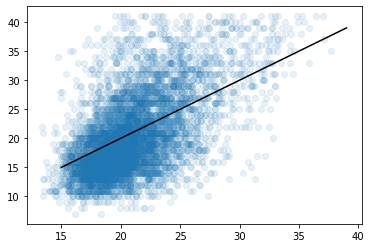

In [868]:
plt.scatter(rf_pred, y_test, alpha=0.1) #plot scatter graph of predicted data from random forest model vs test data
plt.plot(np.arange(15,40),np.arange(15,40), color='k') # plot 1:1 line

### Conclusion
For each algorithm, we:
* calculated the mean squared error
* calculated the root mean squared error
* plotted the predicted values from the model against the actual test data i.e. the 1:1 line where the predicted values from the model would match the actual data

Each model, except for the Random Forest Model, produced a root mean squared error in the range of 6.46 - 6.57 i.e. the difference between the predicted values and the actual values in the test data was approximately 6.5 minutes. 

The Random Forest model produced the lowest mean squared error (MSE) and root mean squared error (RMSE).  It is also visibly closer to the 1:1 line, which means it is the most accurate of the above models.

